# Summarize all experiments
5 datasets. Hiddens. WeightDecays. Dropouts. 
Alphas. Betas. 4 seeds. 

1. GCN L=[2,3,5,10,15]
2. GPCA with beta and alpha tunning 
3. GCN-init L=[2,3,5,10,15]
4. GPCANet with different alpha and beta. L=[1,2,3]
5. Reduce training size GCN-init and GCN. Only on arxiv and products
6. 100 seeds running for comparing GCN-init and GCN, L = [2, 15]

Throw away untrained GPCANet, as we don't need this. 

# Next step
1. Do we need to run additional seeds?
2. Think about sparse coding. 
3. Writing.

In [1]:
import array_to_latex as a2l

In [4]:
import numpy as np, os
def process_file(folder_name, ngpu, model, datasets, *argv):
    valid = True
    sizes = [3]
    sizes.append(len(datasets))
    for values, name, type_ in argv:
        sizes.append(len(values))
    sizes.append(ngpu)
    result = np.zeros(sizes)
    meanings = [arg for arg in argv]

    for data in datasets:   
        for gpu in range(ngpu):
            file_name = os.path.join(folder_name, 'logs', f'gpu{gpu}', f'log-{model}-{data}.txt')
#             print(file_name)
            with open(file_name, 'r') as file:
                lines = filter(lambda x:x[0]=='!' or x[0]=='D', file.readlines())
                for line in lines:
                    line = line.split()
                    if len(line) == 1:
                        configs = line[0].split('-')
                        configs = [ x.split('[') for x in configs]
                        configs = {x[0]:x[1].strip(']') for x in configs}
                        try:
                            indices = [datasets.index(configs['D'])]
                            for values, name, type_ in argv:
                                indices.append(values.index(eval(type_)(configs[name])))
                            indices.append(gpu)
                            valid = True
                        except ValueError:
                            valid = False
                            continue
                        
                    else:
                        if valid:
                            result[tuple([0]+indices)] = float(line[2].strip(',').strip('%'))
                            result[tuple([1]+indices)]  = float(line[4].strip(',').strip('%'))
                            result[tuple([2]+indices)]  = float(line[6].strip(',').strip('%'))  
                            
    return result, meanings

In [6]:
import numpy as np, os
def process_file_(folder_name, seeds, model, datasets, *argv):
    valid = True
    sizes = [3]
    sizes.append(len(datasets))
    for values, name, type_ in argv:
        sizes.append(len(values))
    sizes.append(len(seeds))
    result = np.zeros(sizes)
    path = os.path.join(folder_name, 'logs')
    ngpus = sum(os.path.isdir(os.path.join(path, i)) for i in os.listdir(path))
    for data in datasets: 
        for gpu in range(ngpus):
            file_name = os.path.join(folder_name, 'logs', f'gpu{gpu}', f'log-{model}-{data}.txt')
            try:
                with open(file_name, 'r') as file:
                    lines = filter(lambda x:x[0]=='!' or x[0]=='D', file.readlines())
                    for line in lines:
                        line = line.split()
                        if len(line) == 1:
                            configs = line[0].split('-')
                            if configs[1][-1] != ']':
                                configs[1] += '-'
                                configs[1] += configs.pop(2)
                            configs = [ x.split('[') for x in configs]
                            configs = {x[0]:x[1].strip(']') for x in configs}
                            try:
                                indices = [datasets.index(configs['D'])]
                                for values, name, type_ in argv:
                                    indices.append(values.index(eval(type_)(configs[name])))
                                indices.append(seeds.index(int(configs['seed'])))
                                valid = True
                            except ValueError:
                                valid = False
                                continue

                        else:
                            if valid:
                                result[tuple([0]+indices)] = float(line[2].strip(',').strip('%'))
                                result[tuple([1]+indices)]  = float(line[4].strip(',').strip('%'))
                                result[tuple([2]+indices)]  = float(line[6].strip(',').strip('%')) 
            except FileNotFoundError:
                continue
    return result, [arg for arg in argv]

In [12]:
import copy
def swapPositions(list, pos1, pos2):  
    list[pos1], list[pos2] = list[pos2], list[pos1] 
    return list

def combine_result(result, keepdim=0, return_best_params=True):
    result, meanings = result
    meanings = copy.deepcopy(meanings)
    # result.shape = [train/valid/test, datasets, ..., repeats]
    # always keep [train/valid/test, datasets, repeats]
    # also keep the keepdim which is inside the range.
    flat_shape = result.shape[2:-1] 
    
    if keepdim <= 1:
        #[train/valid/test, datasets, -1, repeats]
        result = result.reshape(*result.shape[:2], -1, result.shape[-1])
    else:
        #[train/valid/test, datasets, keepdim, -1, repeats]
        if return_best_params:
            meanings = swapPositions(meanings, 2-2, keepdim-2)[1:]
        result = result.swapaxes(2, keepdim)
        flat_shape = result.shape[3:-1]
        result = result.reshape(*result.shape[:3], -1, result.shape[-1])
    mean_result = result.mean(-1) #[train/valid/test, datasets, keepdim, -1]
    best_vali_index = mean_result[1].argmax(-1) # datasets, keepdim

    # get best values
    best_test_mean = np.take_along_axis(mean_result[2], 
                                   np.expand_dims(best_vali_index, axis=-1), axis=-1).squeeze(axis=-1)
    best_vali_index.reshape(*best_vali_index.shape, 1,1)
    best_test = np.take_along_axis(result[2], 
                     best_vali_index.reshape(*best_vali_index.shape, 1,1), axis=-2).squeeze()
    # here to report configurations
    if return_best_params:
        unraveled_index = np.unravel_index(best_vali_index, flat_shape)
        readable_best_params = []

        for i, mean in enumerate(meanings):
            m = np.array(mean[0])[unraveled_index[i]].astype('str')
            m = np.char.add(mean[1],m)
            m = np.char.add(m,' ')
            readable_best_params.append(m)
        readable_best_params = np.array(readable_best_params).astype(object)
        readable_best_params = readable_best_params.sum(0)

        return readable_best_params, best_test
    else:
        return best_test

# def combine_result_perseed(result, keepdim=0):
#     # result.shape = [train/valid/test, datasets, ..., repeats]
#     # always keep [train/valid/test, datasets, repeats]
#     # also keep the keepdim which is inside the range.
#     result = result.reshape(*result.shape[:2], -1, result.shape[-1]).swapaxes(-2,-1)
#     best_vali_index = result[1].argmax(-1) # datasets, seeds
#     best_test = np.take_along_axis(result[2], np.expand_dims(best_vali_index, axis=-1), axis=-1).squeeze(axis=-1)
#     return best_test

# GAT

In [27]:
model = 'GAT'
############################
seeds = [105, 15213, 15217, 9195]
datasets=['cora', 'citeseer', 'pubmed']
layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
############################
ccp_gat = process_file_('gat-appnp', seeds, model, datasets, layers, hiddens, weightdecays, dropouts)
ccp_gat_best_params, ccp_gat_test= combine_result(ccp_gat)
print(f'GAT          [cora, citeseer, pubmed] mean={ccp_gat_test.mean(-1)}, std={ccp_gat_test.std(-1)}')

GAT          [cora, citeseer, pubmed] mean=[79.275 69.65  78.225], std=[0.5018715  0.5937171  0.53560713]


In [24]:
model = 'APPNP'
############################
seeds = [105, 15213, 15217, 9195]
datasets=['cora', 'citeseer', 'pubmed']
# layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
############################
ccp_APPNP = process_file_('gat-appnp', seeds, model, datasets, hiddens, weightdecays, dropouts,alphas)
ccp_APPNP_best_params, ccp_APPNP_test= combine_result(ccp_APPNP)
print(f'APPNP          [cora, citeseer, pubmed] mean={ccp_APPNP_test.mean(-1)}, std={ccp_APPNP_test.std(-1)}')

APPNP          [cora, citeseer, pubmed] mean=[81.35  70.325 78.95 ], std=[0.18027756 0.74958322 0.36400549]


In [ ]:
model = 'GAT'
############################
seeds = [105, 15213, 15217, 9195]
datasets=['arxiv']
layers=[[2, 3], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
############################
ccp_gat = process_file_('gat-appnp-ogb', seeds, model, datasets, layers, hiddens, dropouts)
ccp_gat_best_params, ccp_gat_test= combine_result(ccp_gat)
print(f'GAT          [cora, citeseer, pubmed] mean={ccp_gat_test.mean(-1)}, std={ccp_gat_test.std(-1)}')

# APPNP

# cora citeseer pubmed  

In [750]:
model = 'GCN'
ngpu = 4
########################
datasets=['cora', 'citeseer', 'pubmed']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
############################
ccp_gcn = process_file('cora', ngpu, model, datasets, layers, hiddens, weightdecays, dropouts)

In [727]:
model = 'GPCA-Logistic'
ngpu = 4
########################
datasets=['cora', 'citeseer', 'pubmed']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
betas=[[0, 0.1, 0.2], 'b', 'float']
# betas=[[0], 'b', 'float']
############################
ccp_gpca = process_file('cora', ngpu, model, datasets, hiddens, weightdecays, dropouts, alphas, betas)
ccp_gpca[0].shape

(3, 3, 2, 3, 2, 5, 3, 4)

In [691]:
print(combine_result(ccp_gpca)[1].mean(-1))
print(combine_result(ccp_gpca)[1].std(-1))

[81.1   71.8   78.775]
[0.         0.75498344 0.36314598]


In [681]:
combine_result(ccp_gpca)

(array(['h256 wd0.0005 drop0.0 a50 b0 ', 'h256 wd0.05 drop0.0 a5 b0 ',
        'h256 wd0.0005 drop0.5 a10 b0 '], dtype=object),
 array([[81.1, 81.1, 81.1, 81.1],
        [71.1, 72.1, 71.1, 72.9],
        [78.2, 78.8, 78.9, 79.2]]))

In [633]:
ccp_gpca_best_params, ccp_gpca_test = combine_result(ccp_gpca,5)
ccp_gpca_test.mean(-1).T
a2l.to_ltx(ccp_gpca_test.std(-1).T, frmt = '{:6.2f}', arraytype = 'array')

\begin{array}
    0.79 &    0.58 &    0.30\\
    0.17 &    0.75 &    0.29\\
    0.58 &    0.53 &    0.36\\
    0.54 &    0.47 &    0.50\\
    0.00 &    0.32 &    0.19
\end{array}


In [538]:
model = 'GPCANet-Plain'
ngpu = 4
############################
datasets=['cora', 'citeseer', 'pubmed']
layers=[[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
betas=[[0, 0.1, 0.2], 'b', 'float']
############################
ccp_gpcanet = process_file('cora',ngpu, model, datasets, layers, hiddens, weightdecays, dropouts, alphas, betas)
ccp_gpcanet[0].min()

14.28571

In [539]:
model = 'GPCANet-Finetune'
ngpu = 4
############################
datasets=['cora', 'citeseer', 'pubmed']
layers=[[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
alphas=[[1], 'a', 'float'] # add 50  
betas=[[0, 0.1, 0.2], 'b', 'float']
############################
ccp_gpcanet_train = process_file('cora', ngpu, model, datasets, layers, hiddens, weightdecays, dropouts, alphas, betas)
ccp_gpcanet_train[0].min()

14.28571

In [540]:
model = 'GCN-Init'
############################
seeds = [105, 15213, 15217, 9195]
datasets=['cora', 'citeseer', 'pubmed']
layers=[[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
############################
ccp_gcninit = process_file_('cora-gcninit', seeds, model, datasets, layers, hiddens, weightdecays, dropouts)
ccp_gcninit[0].min()

15.0

In [719]:
# for GPCANet with only L123 and various alpha beta
model = 'GPCANet-Finetune'
############################
seeds=[105, 15213, 15217, 9195, 1010]
datasets=['cora', 'citeseer', 'pubmed']
layers=[[1, 2, 3], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
weightdecays = [[5e-4, 5e-3,5e-2], 'wd', 'float']
dropouts = [[0, 0.5], 'drop', 'float']
alphas=[[3,5,10,15,20,30], 'a', 'float'] # add 50  
betas=[[0,0.1,0.2], 'b', 'float']
############################
ccp_gpcanetl123 = process_file_('gpcanetL123', seeds, model, datasets, layers, hiddens, weightdecays, dropouts, alphas, betas)
ccp_gpcanetl123[0].max()

ccp_gpcanetl123_perlayer_best_params, ccp_gpcanetl123_perlayer_test= combine_result(ccp_gpcanetl123, 2)
ccp_gpcanetl123_perlayer_test.mean(-1)

array([[81.58, 80.64, 80.54],
       [71.36, 70.84, 70.56],
       [78.52, 78.52, 78.5 ]])

In [698]:
ccp_gpcanetl123_perlayer_best_params

array([['h128 wd0.005 drop0.5 a30 b0.0 ',
        'h128 wd0.005 drop0.5 a15 b0.1 ',
        'h128 wd0.005 drop0.5 a3 b0.0 '],
       ['h256 wd0.05 drop0.5 a20 b0.1 ',
        'h256 wd0.005 drop0.5 a10 b0.2 ',
        'h256 wd0.0005 drop0.5 a10 b0.2 '],
       ['h256 wd0.0005 drop0.5 a20 b0.2 ',
        'h256 wd0.005 drop0.5 a15 b0.0 ',
        'h256 wd0.005 drop0.5 a3 b0.2 ']], dtype=object)

In [732]:
combine_result(ccp_gpcanetl123)[1].std(-1)

array([0.33823069, 0.21540659, 0.17204651])

In [476]:
ccp_gpcanetl123_perlayer_best_params

array([['h128 wd0.005 drop0.5 a30 b0.0 ',
        'h128 wd0.005 drop0.5 a15 b0.1 ',
        'h128 wd0.005 drop0.5 a3 b0.0 '],
       ['h256 wd0.05 drop0.5 a20 b0.1 ',
        'h256 wd0.005 drop0.5 a10 b0.2 ',
        'h256 wd0.0005 drop0.5 a10 b0.2 '],
       ['h256 wd0.0005 drop0.5 a20 b0.2 ',
        'h256 wd0.005 drop0.5 a15 b0.0 ',
        'h256 wd0.005 drop0.5 a3 b0.2 ']], dtype=object)

### Process
First average the result over runs     
- GCN:  
    1. select the absolute best one    
    2. select the best one for every layer  
- GPCA
    1. select the absolute best one 
    2. select the best one for every alpha 
    3. select the best one for every beta
- GPCANet 
    1. select the absolute best one
    2. select the best one for every layer (ok different beta=0 and beta!=0)
- GPCANet + Finetune
    1. select the absolute best one
    2. select the best one for every layer (ok different beta=0 and beta!=0)

In [191]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

# 1.add GCN+Init. 
# 2.split supervised (beta>0), unsupervised (beta=0) 
# 3.training curve.

In [728]:
# absolute best  (single model the absolue best), report the selected hyperparameter
ccp_gcn_best_params, ccp_gcn_test = combine_result(ccp_gcn)
ccp_gpca_best_params, ccp_gpca_test = combine_result(ccp_gpca)
ccp_gpcanet_best_params, ccp_gpcanet_test = combine_result(ccp_gpcanet)
ccp_gpcanett_best_params, ccp_gpcanett_test = combine_result(ccp_gpcanet_train)
ccp_gcninit_best_params, ccp_gcninit_test = combine_result(ccp_gcninit)

print(f'GCN          [cora, citeseer, pubmed] mean={ccp_gcn_test.mean(-1)}, std={ccp_gcn_test.std(-1)}')
print(f'GPCA         [cora, citeseer, pubmed] mean={ccp_gpca_test.mean(-1)}, std={ccp_gpca_test.std(-1)}')
print(f'GPCANet      [cora, citeseer, pubmed] mean={ccp_gpcanet_test.mean(-1)}, std={ccp_gpcanet_test.std(-1)}')
print(f'GPCANetTrain [cora, citeseer, pubmed] mean={ccp_gpcanett_test.mean(-1)}, std={ccp_gpcanett_test.std(-1)}')
print(f'GCN init     [cora, citeseer, pubmed] mean={ccp_gcninit_test.mean(-1)}, std={ccp_gcninit_test.std(-1)}')
# print(ccp_gcn_test.mean(-1), ccp_gpca_test.mean(-1), 
#       ccp_gpcanet_test.mean(-1), ccp_gpcanet_train_test.mean(-1))

GCN          [cora, citeseer, pubmed] mean=[80.625 71.25  78.425], std=[0.90381137 0.05       0.24874686]
GPCA         [cora, citeseer, pubmed] mean=[81.1   73.2   78.775], std=[0.         0.717635   0.36314598]
GPCANet      [cora, citeseer, pubmed] mean=[82.275 72.075 78.725], std=[0.04330127 0.3344772  0.29474565]
GPCANetTrain [cora, citeseer, pubmed] mean=[80.05  70.6   78.925], std=[1.49248116 0.40620192 0.26809513]
GCN init     [cora, citeseer, pubmed] mean=[80.9   71.075 78.05 ], std=[0.34641016 0.14790199 0.26925824]


In [756]:
# every layer best, need to investigate convergence speed 
ccp_gcn_perlayer_best_params, ccp_gcn_test_perlayer = combine_result(ccp_gcn, 2)
print(ccp_gcn_test_perlayer.std(-1))
ccp_gpcanett_perlayer_best_params, ccp_gpcanett_test_perlayer = combine_result(ccp_gpcanet_train, 2)
print(ccp_gpcanett_test_perlayer.mean(-1))
ccp_gcninit_perlayer_best_params, ccp_gcninit_test_perlayer = combine_result(ccp_gcninit, 2)
print(ccp_gcninit_test_perlayer.std(-1))
# two plots: #hidden 128, 256.
# three curves: gcn , gcn+init(unsupervised), gcn+init(supervised)

[[0.36996621 0.90381137 1.48660687 2.0400674  0.49686517]
 [0.05       0.95       1.99874961 1.97863589 1.14455231]
 [0.24874686 0.25980762 0.24874686 0.69641941 5.10783712]]
[[78.475 80.65  80.05  73.425 67.1  ]
 [70.6   70.225 66.675 58.775 55.4  ]
 [78.925 78.55  77.95  75.275 75.85 ]]
[[0.27726341 0.88317609 0.34641016 0.80738776 1.2708265 ]
 [0.14790199 0.42646805 1.02591423 0.61796035 0.81662415]
 [0.26925824 0.54083269 0.71195154 0.6363961  0.5584577 ]]


In [401]:
ccp_gcn_perlayer_best_params

array([['h128 wd0.005 drop0.5 ', 'h256 wd0.0005 drop0.5 ',
        'h256 wd0.0005 drop0.5 ', 'h256 wd0.0005 drop0.5 ',
        'h256 wd0.0005 drop0.5 '],
       ['h128 wd0.05 drop0.5 ', 'h128 wd0.05 drop0.5 ',
        'h256 wd0.05 drop0.0 ', 'h256 wd0.0005 drop0.0 ',
        'h128 wd0.0005 drop0.0 '],
       ['h128 wd0.005 drop0.5 ', 'h128 wd0.005 drop0.5 ',
        'h128 wd0.0005 drop0.5 ', 'h256 wd0.0005 drop0.0 ',
        'h128 wd0.005 drop0.0 ']], dtype=object)

In [402]:
ccp_gcninit_perlayer_best_params

array([['h128 wd0.05 drop0.5 ', 'h256 wd0.005 drop0.0 ',
        'h256 wd0.0005 drop0.0 ', 'h256 wd0.005 drop0.0 ',
        'h256 wd0.005 drop0.0 '],
       ['h256 wd0.05 drop0.5 ', 'h256 wd0.05 drop0.5 ',
        'h256 wd0.05 drop0.5 ', 'h256 wd0.05 drop0.0 ',
        'h256 wd0.0005 drop0.0 '],
       ['h128 wd0.005 drop0.5 ', 'h256 wd0.005 drop0.5 ',
        'h128 wd0.005 drop0.0 ', 'h128 wd0.005 drop0.0 ',
        'h128 wd0.0005 drop0.0 ']], dtype=object)

In [413]:
np.random.choice(10000, size=100, replace=False)

array([9529, 3885, 4681, 6030, 1521, 2346, 9231,  714, 3869, 3335, 1361,
       8281, 5991, 7675, 9245, 3894, 5398, 3518, 9928, 1899, 6186, 5613,
       1392, 7419, 4856, 4483, 8347, 3245, 8354,  505,  755, 6950, 6107,
       5460, 3712, 2885,  653, 9436,  892, 2300, 3388, 9663, 2761, 9273,
       1101, 9601, 2426,   16, 5782, 6984, 1808,  521, 3529,  350, 2038,
       8654, 1791, 1662,  753, 9994, 4640, 4065, 7819, 1429, 6826, 9824,
       5860,  736, 3468, 6004, 3418,  318,  994, 9445, 2239, 4005, 3022,
       7902, 4666, 8527, 3692, 3318, 9107, 1607,  604, 8331, 3880, 3903,
       7355, 3377, 7583, 1993, 3076, 4867, 5932,   99, 4762, 5732, 4354,
       1657])

In [146]:
ccp_gpcanett_perlayer_best_params

array([['h128 wd0.005 drop0.5 a1 b0.2 ', 'h128 wd0.005 drop0.5 a1 b0.0 ',
        'h128 wd0.005 drop0.0 a1 b0.1 ',
        'h256 wd0.0005 drop0.0 a1 b0.1 ',
        'h256 wd0.0005 drop0.5 a1 b0.0 '],
       ['h256 wd0.05 drop0.5 a1 b0.0 ', 'h128 wd0.005 drop0.5 a1 b0.1 ',
        'h128 wd0.0005 drop0.5 a1 b0.2 ',
        'h256 wd0.005 drop0.0 a1 b0.0 ',
        'h256 wd0.0005 drop0.0 a1 b0.0 '],
       ['h256 wd0.005 drop0.5 a1 b0.0 ', 'h128 wd0.005 drop0.5 a1 b0.2 ',
        'h256 wd0.0005 drop0.5 a1 b0.2 ',
        'h128 wd0.0005 drop0.0 a1 b0.0 ',
        'h256 wd0.0005 drop0.0 a1 b0.0 ']], dtype=object)

In [339]:
ccp_gcn_test128_perlayer = combine_result((ccp_gcn[0][:,:,:,0,:,:,:], None), 2, False)
ccp_gcn_test256_perlayer = combine_result((ccp_gcn[0][:,:,:,1,:,:,:], None), 2, False)

ccp_gcninit_test128_perlayer = combine_result((ccp_gcninit[0][:,:,:,0,:,:,:], None), 2, False)
ccp_gcninit_test256_perlayer = combine_result((ccp_gcninit[0][:,:,:,1,:,:,:], None), 2, False)

In [752]:
def plot_init_acc_vs_layer(A, B):
    layer = [2,3,5,10,15]
    mean = A.mean(-1)
    std = A.std(-1)
    plt.plot(layer, mean, label='Xavier Init')
    plt.fill_between(layer, mean-std, mean+std,alpha=0.2)
    mean = B.mean(-1)
    std = B.std(-1)
    plt.plot(layer, mean, label='GPCANet Init')
    plt.fill_between(layer, mean-std, mean+std,alpha=0.2)
    plt.xlabel('# Layers')
    plt.ylabel('Test Acc')
    


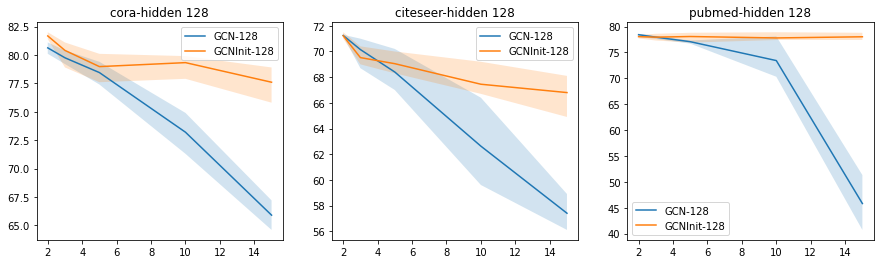

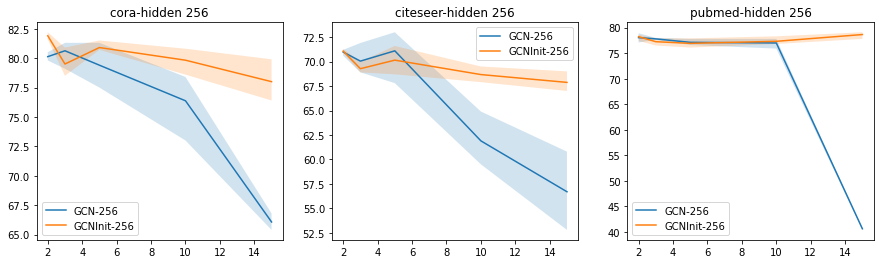

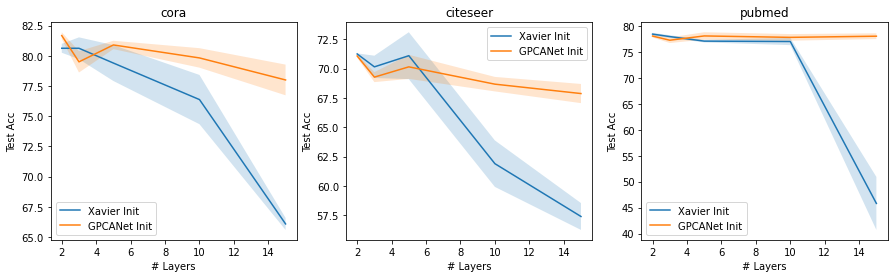

In [753]:
# two plots: #hidden 128, 256.
# three curves: gcn , gcn+init(unsupervised), gcn+init(supervised)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(layers[0], ccp_gcn_test128_perlayer[i].mean(-1), label='GCN-128')
    plt.fill_between(layers[0], ccp_gcn_test128_perlayer[i].min(-1), ccp_gcn_test128_perlayer[i].max(-1),alpha=0.2)
    plt.plot(layers[0], ccp_gcninit_test128_perlayer[i].mean(-1), label='GCNInit-128')
    plt.fill_between(layers[0], ccp_gcninit_test128_perlayer[i].min(-1), ccp_gcninit_test128_perlayer[i].max(-1),alpha=0.2)
#     plt.plot(layers[0], ccp_gcanett_test128s_perlayer[i].mean(-1), label='GPCANet(supervised)-128')
#     plt.fill_between(layers[0], ccp_gcanett_test128s_perlayer[i].min(-1), ccp_gcanett_test128s_perlayer[i].max(-1),alpha=0.2)
    plt.legend()
    plt.title(datasets[i]+'-hidden 128')
plt.figure(figsize=(15,4))  
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(layers[0], ccp_gcn_test256_perlayer[i].mean(-1), label='GCN-256')
    plt.fill_between(layers[0], ccp_gcn_test256_perlayer[i].min(-1), ccp_gcn_test256_perlayer[i].max(-1),alpha=0.2)
    plt.plot(layers[0], ccp_gcninit_test256_perlayer[i].mean(-1), label='GCNInit-256')
    plt.fill_between(layers[0], ccp_gcninit_test256_perlayer[i].min(-1), ccp_gcninit_test256_perlayer[i].max(-1),alpha=0.2)
#     plt.plot(layers[0], ccp_gcanett_test256s_perlayer[i].mean(-1), label='GPCANet(supervised)-256')
#     plt.fill_between(layers[0], ccp_gcanett_test256s_perlayer[i].min(-1), ccp_gcanett_test256s_perlayer[i].max(-1),alpha=0.2)
    plt.legend()
    plt.title(datasets[i]+'-hidden 256')
    
plt.figure(figsize=(15,4))  
for i in range(3):
    plt.subplot(1,3,i+1)
    plot_init_acc_vs_layer(ccp_gcn_test_perlayer[i], ccp_gcninit_test_perlayer[i])
    plt.legend()
    plt.title(datasets[i])

In [169]:
# gpca for different alpha
# alphas=[[1, 5, 10, 20, 50], 'a', 'float'] 
ccp_gpca_alpha_best_params, ccp_gpca_alpha = combine_result(ccp_gpca, 5)
ccp_gpca_alpha.mean(-1)
# gpca for different beta
#ccp_gpca_alpha_best_params

array([[72.575, 80.95 , 82.225, 82.05 , 81.1  ],
       [70.9  , 72.175, 70.9  , 71.5  , 73.2  ],
       [76.925, 79.4  , 78.775, 78.15 , 78.   ]])

In [170]:
ccp_gpca_alpha_best_params

array([['wd0.05 drop0.5 h256 b0.0 ', 'wd0.005 drop0.5 h128 b0.0 ',
        'wd0.005 drop0.5 h128 b0.0 ', 'wd0.005 drop0.5 h256 b0.0 ',
        'wd0.0005 drop0.0 h256 b0.0 '],
       ['wd0.05 drop0.0 h128 b0.0 ', 'wd0.05 drop0.0 h256 b0.1 ',
        'wd0.05 drop0.5 h256 b0.2 ', 'wd0.005 drop0.0 h128 b0.2 ',
        'wd0.05 drop0.5 h256 b0.2 '],
       ['wd0.0005 drop0.5 h128 b0.0 ', 'wd0.0005 drop0.5 h128 b0.0 ',
        'wd0.0005 drop0.5 h256 b0.0 ', 'wd0.0005 drop0.5 h256 b0.0 ',
        'wd0.0005 drop0.5 h256 b0.0 ']], dtype=object)

In [168]:
# gpca for different beta
# betas=[[0, 0.1, 0.2], 'b', 'float']
ccp_gpca_beta_best_params, ccp_gpca_beta = combine_result(ccp_gpca, 6)
ccp_gpca_beta.mean(-1)

array([[81.1  , 81.175, 81.9  ],
       [71.8  , 72.075, 73.2  ],
       [78.775, 79.4  , 78.725]])

In [171]:
ccp_gpca_beta_best_params

array([['wd0.0005 drop0.0 a50 h256 ', 'wd0.0005 drop0.5 a50 h128 ',
        'wd0.0005 drop0.0 a20 h128 '],
       ['wd0.05 drop0.0 a5 h256 ', 'wd0.05 drop0.0 a10 h256 ',
        'wd0.05 drop0.5 a50 h256 '],
       ['wd0.0005 drop0.5 a10 h256 ', 'wd0.0005 drop0.5 a5 h128 ',
        'wd0.0005 drop0.5 a5 h128 ']], dtype=object)

# Arxiv

In [745]:
model = 'GCN'
ngpu = 4
########################
seeds = [105, 15213, 15217, 9195]
datasets=['arxiv']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
############################
arxiv_gcn = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts)
arxiv_gcn_l15 = process_file_('arxiv-products-gcninit', seeds, model, datasets, layers, hiddens, dropouts)
arxiv_gcn[0][:,:,4,:,:,:] = arxiv_gcn_l15[0][:,:,4,:,:,:]
arxiv_gcn[0].min()

40.07213

In [636]:
model = 'GPCA-Logistic'
ngpu = 4
########################
datasets=['arxiv']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
betas=[[0, 0.1, 0.2], 'b', 'float']
############################
arxiv_gpca = process_file('arxiv-products', ngpu, model, datasets, hiddens, dropouts, alphas, betas)
arxiv_gpca[0].shape

(3, 1, 2, 2, 5, 3, 4)

In [644]:
combine_result(arxiv_gpca, 4)[1].std(-1)


array([0.26444542, 0.11441528, 0.09364146, 0.18148167, 0.15577969])

In [551]:
model = 'GPCANet-Plain'
ngpu = 4
############################
datasets=['arxiv']
layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
betas=[[0, 0.1, 0.2], 'b', 'float']
############################
arxiv_gpcanet = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts, alphas, betas)
arxiv_gpcanet[0].min()

44.8532

In [552]:
model = 'GPCANet-Finetune'
ngpu = 4
############################
datasets=['arxiv']
layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
alphas=[[0.5, 1, 5], 'a', 'float'] # 0.5 works great! it seems we should shrink a to achieve better high result
betas=[[0, 0.1, 0.2], 'b', 'float']
############################
arxiv_gpcanet_train = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts, alphas, betas)
arxiv_gpcanet_train[0].min()

62.11962

In [553]:
model = 'GCN-Init'
########################
seeds = [105, 15213, 15217, 9195]
datasets=['arxiv']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
############################
arxiv_gcninit = process_file_('arxiv-products-gcninit', seeds, model, datasets, layers, hiddens, dropouts)
arxiv_gcninit[0].min()

64.98776

In [704]:
# for GPCANet with only L123 and various alpha beta
model = 'GPCANet-Finetune'
############################
seeds=[105, 15213, 15217, 9195]
datasets=['arxiv']
layers=[[1, 2, 3], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.2], 'drop', 'float']
alphas=[[3,5,10,15,20,30], 'a', 'float'] # add 50  
############################
arxiv_gpcanetl123 = process_file_('gpcanetL123', seeds, model, datasets, layers, hiddens, dropouts, alphas)

arxiv_gpcanetl123_perlayer_best_params, arxiv_gpcanetl123_perlayer_test= combine_result(arxiv_gpcanetl123, 2)
arxiv_gpcanetl123_perlayer_test.mean(-1)
#arxiv_gpcanetl123_perlayer_test.std(-1)
#combine_result(arxiv_gpcanetl123)[1].mean()
#combine_result(arxiv_gpcanetl123)[1].std()

array([71.756375 , 72.204905 , 71.9857825])

In [733]:
combine_result(arxiv_gpcanetl123)[1].std(-1)

0.15693359272316404

In [474]:
arxiv_gpcanetl123_perlayer_best_params

array([['h256 drop0.2 a10 ', 'h256 drop0.2 a5 ', 'h256 drop0.2 a3 ']],
      dtype=object)

In [475]:
arxiv_gpca_best_params

array(['h256 drop0.2 a20 b0.0 '], dtype=object)

In [469]:
arxiv_gpcanetl123_perlayer_test.std(-1)

array([0.08504761, 0.15693359, 0.20501453])

In [555]:
# absolute best
arxiv_gcn_best_params, arxiv_gcn_test = combine_result(arxiv_gcn)
arxiv_gpca_best_params, arxiv_gpca_test = combine_result(arxiv_gpca)
arxiv_gpcanet_best_params, arxiv_gpcanet_test = combine_result(arxiv_gpcanet)
arxiv_gpcanetp_best_params, arxiv_gpcanetp_test = combine_result(arxiv_gpcanet_train)
arxiv_gcninit_best_params, arxiv_gcninit_test = combine_result(arxiv_gcninit)
print(f'GCN           mean={arxiv_gcn_test.mean(-1)}, std={arxiv_gcn_test.std(-1)}')
print(f'GCNInit       mean={arxiv_gcninit_test.mean(-1)}, std={arxiv_gcninit_test.std(-1)}')
print(f'GPCA          mean={arxiv_gpca_test.mean(-1)}, std={arxiv_gpca_test.std(-1)}')
print(f'GPCANet       mean={arxiv_gpcanet_test.mean(-1)}, std={arxiv_gpcanet_test.std(-1)}')
print(f'GPCANetTrain  mean={arxiv_gpcanetp_test.mean(-1)}, std={arxiv_gpcanetp_test.std(-1)}')

GCN           mean=70.649445, std=0.1706953769877804
GCNInit       mean=70.7266, std=0.16273207597151818
GPCA          mean=71.8582175, std=0.18148167075148514
GPCANet       mean=71.88908250000001, std=0.05185308061002634
GPCANetTrain  mean=72.3422425, std=0.11948196231544939


In [269]:
arxiv_gpca_best_params

array(['h256 drop0.2 a20 b0.0 '], dtype=object)

In [266]:
arxiv_gpcanetp_best_params

array(['l2 h256 drop0.2 a5.0 b0.0 '], dtype=object)

In [360]:
# every layer best, need to investigate convergence speed
arxiv_gcn_perlayer_best_params, arxiv_gcn_test_perlayer = combine_result(arxiv_gcn, 2)
print(arxiv_gcn_test_perlayer.mean(-1))
arxiv_gpcanetp_perlayer_best_params, arxiv_gcanetp_test_perlayer = combine_result(arxiv_gpcanet_train, 2)
print(arxiv_gcanetp_test_perlayer.mean(-1))

arxiv_gcninit_perlayer_best_params, arxiv_gcninit_test_perlayer = combine_result(arxiv_gcninit, 2)
print(arxiv_gcninit_test_perlayer.mean(-1))

[69.6135    70.649445  70.33928   68.328605  61.6844625]
[72.3422425 71.8705625 71.5830275 71.72654  ]
[69.765755  70.7266    70.5208525 69.77347   66.2808875]


In [404]:
arxiv_gcninit_perlayer_best_params

array([['h256 drop0.2 ', 'h256 drop0.2 ', 'h256 drop0.2 ',
        'h256 drop0.2 ', 'h128 drop0.2 ']], dtype=object)

In [744]:
layers

[[2, 3, 5, 10, 15], 'l', 'int']

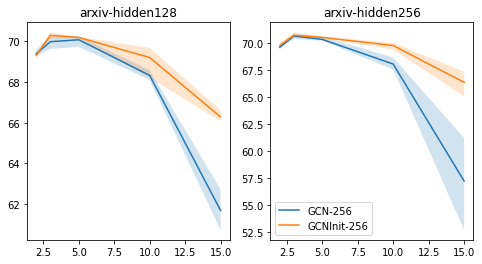

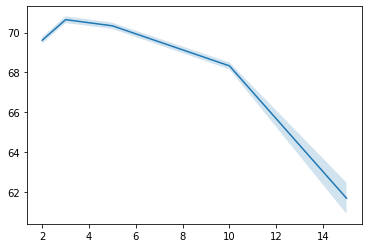

In [747]:
arxiv_gcn_test128_perlayer = combine_result((arxiv_gcn[0][:,:,:,0,:,:], None), 2, False)
arxiv_gcn_test256_perlayer = combine_result((arxiv_gcn[0][:,:,:,1,:,:], None), 2, False)

arxiv_gcninit_test128_perlayer = combine_result((arxiv_gcninit[0][:,:,:,0,:,:], None), 2, False)
arxiv_gcninit_test256_perlayer = combine_result((arxiv_gcninit[0][:,:,:,1,:,:], None), 2, False)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(layers[0], arxiv_gcn_test128_perlayer.mean(-1), label='GCN-128')
plt.fill_between(layers[0], arxiv_gcn_test128_perlayer.min(-1), arxiv_gcn_test128_perlayer.max(-1),alpha=0.2)
plt.plot(layers[0], arxiv_gcninit_test128_perlayer.mean(-1), label='GCNInit-128')
plt.fill_between(layers[0], arxiv_gcninit_test128_perlayer.min(-1), arxiv_gcninit_test128_perlayer.max(-1),alpha=0.2)
plt.title('arxiv-hidden128')
plt.subplot(1,2,2)
plt.plot(layers[0], arxiv_gcn_test256_perlayer.mean(-1), label='GCN-256')
plt.fill_between(layers[0], arxiv_gcn_test256_perlayer.min(-1), arxiv_gcn_test256_perlayer.max(-1),alpha=0.2)
plt.plot(layers[0], arxiv_gcninit_test256_perlayer.mean(-1), label='GCNInit-256')
plt.fill_between(layers[0], arxiv_gcninit_test256_perlayer.min(-1), arxiv_gcninit_test256_perlayer.max(-1),alpha=0.2)
plt.title('arxiv-hidden256')
plt.legend()



plt.figure()
mean = arxiv_gcn_test_perlayer.mean(-1)
std = arxiv_gcn_test_perlayer.std(-1)
plt.plot(layers[0], mean, label='Xavier Init')
plt.fill_between(layers[0], mean-std, mean+std,alpha=0.2)

mean = arxiv_gcn_test_perlayer.mean(-1)
std = arxiv_gcn_test_perlayer.std(-1)
plt.plot(layers[0], mean, label='Xavier Init')
plt.fill_between(layers[0], mean-std, mean+std,alpha=0.2)

## 1. I have observed that remove mean in GPCANet forward makes the training a lot faster and get better accuracy

## 2. Adding beta cause overfit. Training becomes easier. 

## 3. reduce mean also helps GCN for both arxiv and products?



products prefer a = 1 for any layers. [Less smoothing]
arxiv prefer a = 5 with 3 layers. 

In [236]:
arxiv_gcn_perlayer_best_params

array([['h256 drop0.2 ', 'h256 drop0.2 ', 'h256 drop0.2 ',
        'h128 drop0.2 ']], dtype=object)

# Products

In [758]:
model = 'GCN'
ngpu = 4
seeds = [105, 15213, 15217, 9195] # another seed 1010 available
########################
datasets=['products']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
############################
products_gcn = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts)
temp = process_file_('products256', seeds, model, datasets, layers, hiddens, dropouts)
# print(products_gcn[0].shape)
products_gcn[0][:,:,:,1,:,:] = temp[0][:,:,:,1,:,:]
products_gcn_l15 = process_file_('arxiv-products-gcninit', seeds, model, datasets, layers, hiddens, dropouts)
products_gcn[0][:,:,4,:,:,:] = products_gcn_l15[0][:,:,4,:,:,:]
# products_gcn[0][2]
#products_gcn.m()
# process_file_singlegpu('products256', seeds, model, datasets, layers, [[256], 'h', 'int'], dropouts).shape

In [304]:
model = 'GPCA-Logistic'
ngpu = 4
########################
datasets=['products']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
alphas=[[1, 5, 10, 20, 50], 'a', 'float'] # add 50  
############################
products_gpca = process_file('arxiv-products', ngpu, model, datasets, hiddens, dropouts, alphas)
temp = process_file_('products256', seeds, model, datasets, hiddens, dropouts, alphas)
products_gpca[0][:,:,1,:,:,:] = temp[0][:,:,1,:,:,:]

In [647]:
combine_result(products_gpca, 4)[1].std(-1)

array([0.07329416, 0.09668001, 0.09455461, 0.14279445, 0.09912705])

In [305]:
model = 'GPCANet-Plain'
ngpu = 4
############################
datasets=['products']
layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
alphas=[[1, 5], 'a', 'float'] # problem! 0.5 is not running
############################
products_gpcanet = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts, alphas)
temp = process_file_('products256', seeds, model, datasets, layers, hiddens, dropouts, alphas)
products_gpcanet[0][:,:,:,1,:,:,:] = temp[0][:,:,:,1,:,:,:]

In [394]:
model = 'GPCANet-Finetune'
ngpu = 4
############################
datasets=['products']
layers=[[2, 3, 5, 10], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
alphas=[[1], 'a', 'float'] # add 50  
############################
products_gpcanet_train = process_file('arxiv-products', ngpu, model, datasets, layers, hiddens, dropouts, alphas)
temp = process_file_('products256', seeds, model, datasets, layers, hiddens, dropouts, alphas)
products_gpcanet_train[0][:,:,:,1,:,:,:] = temp[0][:,:,:,1,:,:,:]
# products_gpcanet_train[0][:,:,:,:,1,:,:] = temp[:,:,:,:,1,:,:]
# products_gpcanet_train[0].min()

In [759]:
model = 'GCN-Init'
########################
seeds = [105, 15213, 15217, 9195]
datasets=['products']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
############################
products_gcninit = process_file_('arxiv-products-gcninit', seeds, model, datasets, layers, hiddens, dropouts)
products_gcninit[0].min()

74.3227

In [710]:
# for GPCANet with only L123 and various alpha beta
model = 'GPCANet-Finetune'
############################
seeds=[105, 15213, 15217, 9195]
datasets=['products']
layers=[[1, 2, 3], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
dropouts = [[0, 0.1], 'drop', 'float']
alphas=[[1,2,5,10,15], 'a', 'float'] # add 50  
############################
products_gpcanetl123 = process_file_('gpcanetL123', seeds, model, datasets, layers, hiddens, dropouts, alphas)

products_gpcanetl123_perlayer_best_params, products_gpcanetl123_perlayer_test= combine_result(products_gpcanetl123, 2)
products_gpcanetl123_perlayer_test.mean(-1)
#combine_result(products_gpcanetl123)[1].mean()
#combine_result(products_gpcanetl123)[0]

array([78.1221275, 79.44844  , 80.0563775])

In [735]:
combine_result(products_gpcanetl123)

(array(['l3 h256 drop0.1 a1 '], dtype=object),
 array([79.8945 , 80.51603, 79.73829, 80.07669]))

In [472]:
products_gpcanetl123_perlayer_best_params

array([['h256 drop0.1 a5 ', 'h256 drop0.1 a2 ', 'h256 drop0.1 a1 ']],
      dtype=object)

In [473]:
products_gpca_best_params

array(['h256 drop0.1 a20 '], dtype=object)

In [471]:
products_gpcanetl123_perlayer_test.std(-1)

array([0.18364769, 0.26333954, 0.29115159])

In [395]:
products_gcn_best_params, products_gcn_test = combine_result(products_gcn)
products_gcninit_best_params, products_gcninit_test = combine_result(products_gcninit)
products_gpca_best_params, products_gpca_test = combine_result(products_gpca)
products_gpcanet_best_params, products_gpcanet_test = combine_result(products_gpcanet)
products_gpcanetp_best_params, products_gpcanetp_test = combine_result(products_gpcanet_train)
print(f'GCN           mean={products_gcn_test.mean(-1)}, std={products_gcn_test.std(-1)}')
print(f'GCNInit       mean={products_gcninit_test.mean(-1)}, std={products_gcninit_test.std(-1)}')
print(f'GPCA          mean={products_gpca_test.mean(-1)}, std={products_gpca_test.std(-1)}')
print(f'GPCANet       mean={products_gpcanet_test.mean(-1)}, std={products_gpcanet_test.std(-1)}')
print(f'GPCANetTrain  mean={products_gpcanetp_test.mean(-1)}, std={products_gpcanetp_test.std(-1)}')

GCN           mean=77.90110250000001, std=0.3260340044669418
GCNInit       mean=78.1373875, std=0.17635724359591853
GPCA          mean=79.22966250000002, std=0.14279444743669217
GPCANet       mean=79.1522575, std=0.13540747807543868
GPCANetTrain  mean=79.316745, std=0.20758767177989876


In [396]:
products_gpca_best_params

array(['h256 drop0.1 a20 '], dtype=object)

In [397]:
products_gpcanet_best_params

array(['l5 h256 drop0.1 a1 '], dtype=object)

In [760]:
# every layer best, need to investigate convergence speed
products_gcn_perlayer_best_params, products_gcn_test_perlayer = combine_result(products_gcn, 2)
print(products_gcn_test_perlayer.mean(-1))
products_gcanetp_perlayer_best_params, products_gcanetp_test_perlayer = combine_result(products_gpcanet_train, 2)
print(products_gcanetp_test_perlayer.mean(-1))

products_gcninit_perlayer_best_params, products_gcninit_test_perlayer = combine_result(products_gcninit, 2)
print(products_gcninit_test_perlayer.mean(-1))

[77.9011025 78.6506075 78.0846    76.2738625 74.7020925]
[78.08645   79.316745  78.9547275 77.305115 ]
[78.1373875 78.7102275 78.2258825 77.469555  75.9015325]


In [278]:
products_gcn_perlayer_best_params

array([['h256 drop0.0 ', 'h256 drop0.0 ', 'h256 drop0.0 ',
        'h256 drop0.1 ']], dtype=object)

In [384]:
products_gcanetp_perlayer_best_params

array([['h128 drop0.0 a5 ', 'h128 drop0.0 a5 ', 'h128 drop0.1 a5 ',
        'h128 drop0.0 a5 ']], dtype=object)

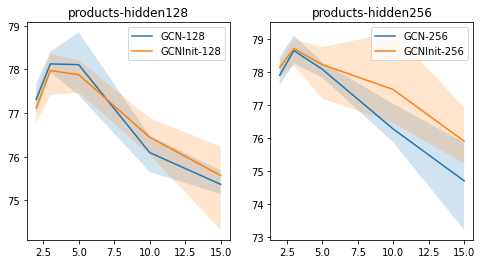

In [380]:
products_gcn_test128_perlayer = combine_result((products_gcn[0][:,:,:,0,:,:], None), 2, False)
products_gcn_test256_perlayer = combine_result((products_gcn[0][:,:,:,1,:,:], None), 2, False)

products_gcninit_test128_perlayer = combine_result((products_gcninit[0][:,:,:,0,:,:], None), 2, False)
products_gcninit_test256_perlayer = combine_result((products_gcninit[0][:,:,:,1,:,:], None), 2, False)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(layers[0], products_gcn_test128_perlayer.mean(-1), label='GCN-128')
plt.fill_between(layers[0], products_gcn_test128_perlayer.min(-1), products_gcn_test128_perlayer.max(-1),alpha=0.2)
plt.plot(layers[0], products_gcninit_test128_perlayer.mean(-1), label='GCNInit-128')
plt.fill_between(layers[0], products_gcninit_test128_perlayer.min(-1), products_gcninit_test128_perlayer.max(-1),alpha=0.2)
plt.title('products-hidden128')
plt.legend()
plt.subplot(1,2,2)
plt.plot(layers[0], products_gcn_test256_perlayer.mean(-1), label='GCN-256')
plt.fill_between(layers[0], products_gcn_test256_perlayer.min(-1), products_gcn_test256_perlayer.max(-1),alpha=0.2)
plt.plot(layers[0], products_gcninit_test256_perlayer.mean(-1), label='GCNInit-256')
plt.fill_between(layers[0], products_gcninit_test256_perlayer.min(-1), products_gcninit_test256_perlayer.max(-1),alpha=0.2)
plt.title('products-hidden256')
plt.legend()

# TODO
# write a scrip for all dataset, only study this.
1. Add 0.5 train for all data  
2. We focus on test high number of layers with alpha < 1 [small alpha combines with larger number of layers]


# Focus on GPCANet with Finetune. 
# Plain GPCANet is not good. We start to ignore it
# (0.5 0.2)? Talk about this with Leman.  
# Layer number? Need to test with 
 
When α < 1, Eq. (9) shows the connection between GPCA
and graph convolution with 1-step residual.
# Also, show training curve is faster. 

# New Experiments
1. Run GCN+init for all datasets. [Code=>run_gcninit.sh]  [Done!]
    - For current datasets configurations
  
2. Test new GPCANet+Finetune with alpha < 1. Also, for small dataset cora citeseer and pubmed maybe remove the last linear layer to avoid overfit. Need a bit test. (I think it's fine) 

3. Test new dataset setting for arxiv and products: 1% training. GCN vs GCN+init

4. GCN+init with different beta



5. hidden 64 (but not really need for arxiv and products)




5. Center=False for GPCANet 
6. +- init for GCN and GPCANet

In [ ]:
# Two things want to discuss with Leman
# 1. init with +- definitely works a lot better
# 2. init with GPCANet works better in a common setting. (for example take mean instead of max across hps)


# To show the benefit of init：
# for each GCN configuration, find the best hyperparameter, and run use init. 
# this save time but give a little disadvantage to GCN+init

# 1. GCN init [Done, additional: with different alpba and beta] 
Always use local machine to run cora citeseer and pubmed. 

1. GCN init [Done, additional: with different alpba and beta when using power method] 

2. [TODO] init with different beta and alpba: alphas [0.2 0.5 5]   beta[0.1 0.2]



# 2. GPCANet . With carefully select layers and alphas betas [Done]

Always use local machine to run cora citeseer and pubmed. 


1. Focus on GPCANet+Finetune with alpha < 1, and try to train deep models. 
2. Test the new performance for GPCANet (as we add back mean)

This model enlarged GCN. Need to carefully evaluate. 

专门写一个file for GPCANetFinetune
1. 只有一层layer的, train it.  [L=1 a=20, L=2 a=10, L=3 a=5]
2. fix 10层的? with alpha < 1? 并没有看到高层低alpha带来的优势



TODO: Need to choose alpbas and betas

alphas = [0.2 0.5 2 5]
betas = [] later? 
How to minimize the number of runs:
1. first report the best configurations and find some patterns [Done]


2. alpha large, with nlayer = 1[want to test] 2 3
3. alpha small with nlayer 10 15 20?

# 3. Reduce training size of arxiv and products [Done]
we can keep the validation and test set fixed. And only downsampling the training set. 
Then we can keep the realistic setting of the data split and only harder the problem. 

0. only 2 datasets
1. Run GCN
2. Run GCN-init

[[62.684196 62.810116 61.68755  59.187292 53.655946]
 [68.225996 69.089114 70.155542 70.370742 68.255142]]
[[62.802708 63.091578 62.50067  61.0522   59.159724]
 [68.12967  69.350866 70.322178 71.15394  70.39611 ]]


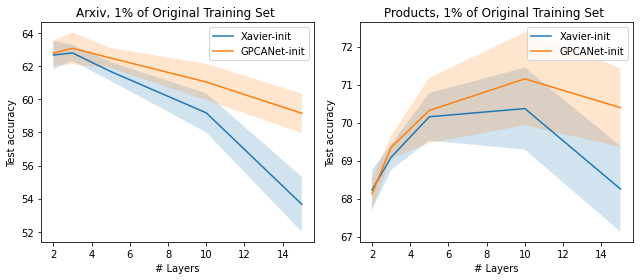

In [813]:
folder_name = 'downsampled'
seeds = [105, 15213, 15217, 9195, 1010]
datasets = ['arxiv', 'products']
names = ['Arxiv', 'Products']
layers = [[2, 3, 5, 10, 15], 'l', 'int']
hiddens = [[128, 256], 'h', 'int']
gcn_downsampled = process_file_(folder_name, seeds, 'GCN', datasets,  layers, hiddens)
gcninit_downsampled = process_file_(folder_name, seeds, 'GCN-Init', datasets,  layers, hiddens)
_, gcn_downsampled = combine_result(gcn_downsampled, 2)
_, gcninit_downsampled = combine_result(gcninit_downsampled, 2)
print(gcn_downsampled.mean(-1))
print(gcninit_downsampled.mean(-1))
plt.figure(figsize=(9,4))
for d, data in enumerate(datasets):
    plt.subplot(1,2,1+d)
    plt.plot(layers[0], gcn_downsampled.mean(-1)[d], label='Xavier-init')
    plt.fill_between(layers[0], 
                     gcn_downsampled.mean(-1)[d] - gcn_downsampled.std(-1)[d], 
                     gcn_downsampled.mean(-1)[d] + gcn_downsampled.std(-1)[d],
                     alpha=0.2)
    plt.plot(layers[0], gcninit_downsampled.mean(-1)[d], label='GPCANet-init')
    plt.fill_between(layers[0], 
                     gcninit_downsampled.mean(-1)[d] - gcninit_downsampled.std(-1)[d], 
                     gcninit_downsampled.mean(-1)[d] + gcninit_downsampled.std(-1)[d],
                     alpha=0.2)
    plt.title(f'{names[d]}, 1% of Original Training Set ')
    plt.xlabel('# Layers')
    plt.ylabel('Test accuracy')
    plt.legend()
plt.tight_layout()
plt.savefig('figs/downsampled.pdf')

# 4. 100 seeds for GCN and GCNInit, Layer 2 and Layer 15.  

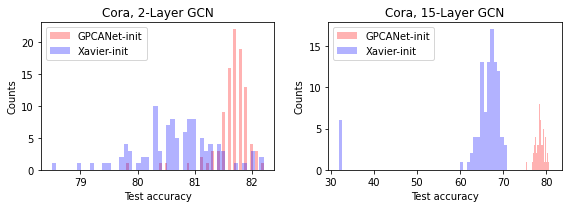

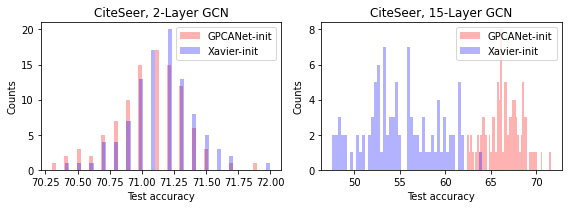

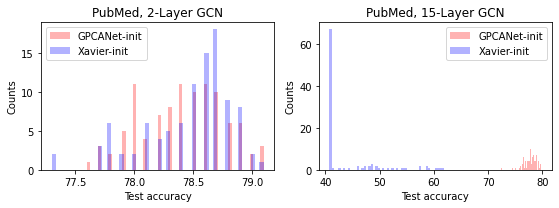

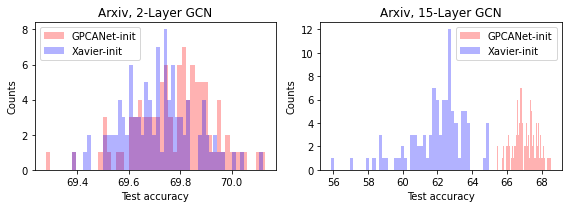

In [820]:
# 100 seeds, GCN vs GCN-init. Best params. L2 and L15
# cora citeseer pubmed arxiv
folder_name = '100seeds'
############################
seeds = [9529, 3885, 4681, 6030, 1521, 2346, 9231,  714, 3869, 3335, 1361,
       8281, 5991, 7675, 9245, 3894, 5398, 3518, 9928, 1899, 6186, 5613,
       1392, 7419, 4856, 4483, 8347, 3245, 8354,  505,  755, 6950, 6107,
       5460, 3712, 2885,  653, 9436,  892, 2300, 3388, 9663, 2761, 9273,
       1101, 9601, 2426,   16, 5782, 6984, 1808,  521, 3529,  350, 2038,
       8654, 1791, 1662,  753, 9994, 4640, 4065, 7819, 1429, 6826, 9824,
       5860,  736, 3468, 6004, 3418,  318,  994, 9445, 2239, 4005, 3022,
       7902, 4666, 8527, 3692, 3318, 9107, 1607,  604, 8331, 3880, 3903,
       7355, 3377, 7583, 1993, 3076, 4867, 5932,   99, 4762, 5732, 4354,
       1657]
datasets=['cora', 'citeseer', 'pubmed', 'arxiv']
names = ['Cora', 'CiteSeer', 'PubMed', 'Arxiv']
layers=[[2, 15], 'l', 'int']
############################
gcn100seeds = process_file_(folder_name, seeds, 'GCN', datasets, layers)[0][2]
gcninit100seeds = process_file_(folder_name, seeds, 'GCN-Init', datasets, layers)[0][2]
gcninit100seeds.shape

for d in range(len(datasets)):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    l=0
    plt.hist(gcninit100seeds[d,l], bins=50, color='red', alpha=0.3, label='GPCANet-init')
    plt.hist(gcn100seeds[d,l], bins=50, color='blue', alpha=0.3, label='Xavier-init')
    plt.title(f'{names[d]}, {layers[0][l]}-Layer GCN')
    plt.xlabel('Test accuracy')
    plt.ylabel('Counts')
    plt.legend()
    plt.subplot(1,2,2)
    l=1
    plt.hist(gcninit100seeds[d,l], bins=50, color='red', alpha=0.3, label='GPCANet-init')
    plt.hist(gcn100seeds[d,l], bins=50, color='blue', alpha=0.3, label='Xavier-init')
    plt.title(f'{names[d]}, {layers[0][l]}-Layer GCN')
    plt.xlabel('Test accuracy')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs/{datasets[d]}-init-robust.pdf')

# Plot the training curve of both GCN and GCN-init. For all datasets.

Need to access the numpy file.

(5, 20, 4) (5, 20, 4)
(5, 200, 4) (5, 200, 5)


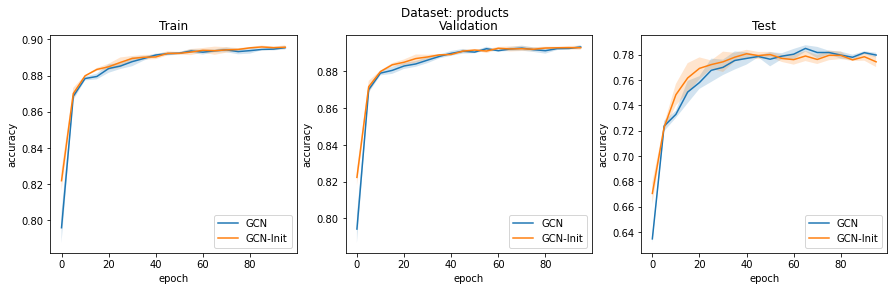

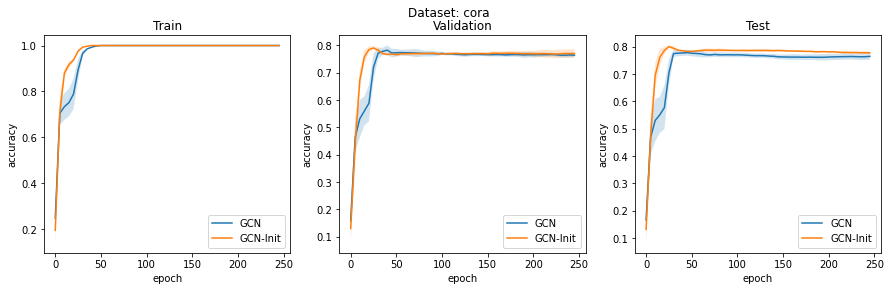

In [823]:
# For each dataset, find a specific configuration (best for gcn? 
# or just a normal configeration for fairness), and find the all seeds. 
# Get numpy 
def fetch_training_curve(folder, seeds, model, dataset, configs):
    results = []
    for gpu in range(4):
        dirname = os.path.join(folder, 'results', f'gpu{gpu}', 'benchmarks')
        if os.path.exists(dirname):
            for subdir in os.listdir(dirname):
                if f'M[{model}]' not in subdir:
                    continue
                if f'D[{dataset}]' not in subdir:
                    continue
                
                exist = True
                for key, item in configs.items():
                    if f'{key}[{item}]' not in subdir:
                        exist = False
                        break
                if not exist:
                    continue
                record_file = os.path.join(dirname, subdir, 'training_curves.npy')
                results.append(np.load(record_file).T)
    
    return np.stack(results, -1)

def plot_training(data, recordA, recordB, k=50):
    plt.figure(figsize=(15,4)) 
    plt.suptitle(f'Dataset: {data}')
    print(recordA.shape, recordB.shape)
    meanA = recordA.mean(-1)[:,:k]
    meanB = recordB.mean(-1)[:,:k]
    stdA = recordA.std(-1)[:,:k]
    stdB = recordB.std(-1)[:,:k]
    
    plt.subplot(1,3,1)
    plt.title('Train')
    plt.plot(meanA[0], meanA[2], label='GCN')
    plt.fill_between(meanA[0], meanA[2] - stdA[2], meanA[2] + stdA[2], alpha=0.2)
    plt.plot(meanB[0], meanB[2], label='GCN-Init')
    plt.fill_between(meanB[0], meanB[2] - stdB[2], meanB[2] + stdB[2], alpha=0.2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.title('Validation')
    plt.plot(meanA[0], meanA[3], label='GCN')
    plt.fill_between(meanA[0], meanA[3] - stdA[3], meanA[3] + stdA[3], alpha=0.2)
    plt.plot(meanB[0], meanB[3], label='GCN-Init')
    plt.fill_between(meanB[0], meanB[3] - stdB[3], meanB[3] + stdB[3], alpha=0.2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Test')
    plt.plot(meanA[0], meanA[4], label='GCN')
    plt.fill_between(meanA[0], meanA[4] - stdA[4], meanA[4] + stdA[4], alpha=0.2)
    plt.plot(meanB[0], meanB[4], label='GCN-Init')
    plt.fill_between(meanB[0], meanB[4] - stdB[4], meanB[4] + stdB[4], alpha=0.2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

L = 5
seeds = [105, 15213, 15217, 9195, 1010]
configs={'l': L, 
     'h':128, 
     'wd':'0.0', 'drop':'0.0',
     'a':1, 'b':0}
data = 'products'
if L == 15:
    gcn_curve = fetch_training_curve('arxiv-products-gcninit', seeds, 'GCN', data, configs)
else:
    gcn_curve = fetch_training_curve('arxiv-products', seeds, 'GCN', data, configs)
gcninit_curve = fetch_training_curve('arxiv-products-gcninit', seeds, 'GCN-Init', data, configs)
plot_training(data, gcn_curve, gcninit_curve)

configs={'l': L, 
     'h':128, 
     'wd':'0.005', 'drop':'0.0',
     'a':1, 'b':0}
data = 'cora'
gcn_curve = fetch_training_curve('cora', seeds, 'GCN', data, configs)
gcninit_curve = fetch_training_curve('cora-gcninit', seeds, 'GCN-Init', data, configs)
plot_training(data, gcn_curve, gcninit_curve)

In [503]:
fetch_training_curve()

['products256',
 'arxiv-products',
 'arxiv-products-gcninit',
 'cora-gcninit',
 'gpcanetL123',
 'result.ipynb',
 '.ipynb_checkpoints',
 'cora',
 '100seeds',
 'downsampled']

# Plot the average instead of maximum validation performance verse #layers
This can be remvoed. As the histogram already show the things? 
Robustness across configurations maybe not necessary.


In [415]:
# Should I add more seeds? 